Arquivo CSV 'produtos.csv' gerado com sucesso!
Arquivo Excel 'produtos.xlsx' gerado com sucesso!
Média: R$ 534.27
Mediana: R$ 312.11
Desvio Padrão: R$ 596.83
Variância: R$ 356203.20


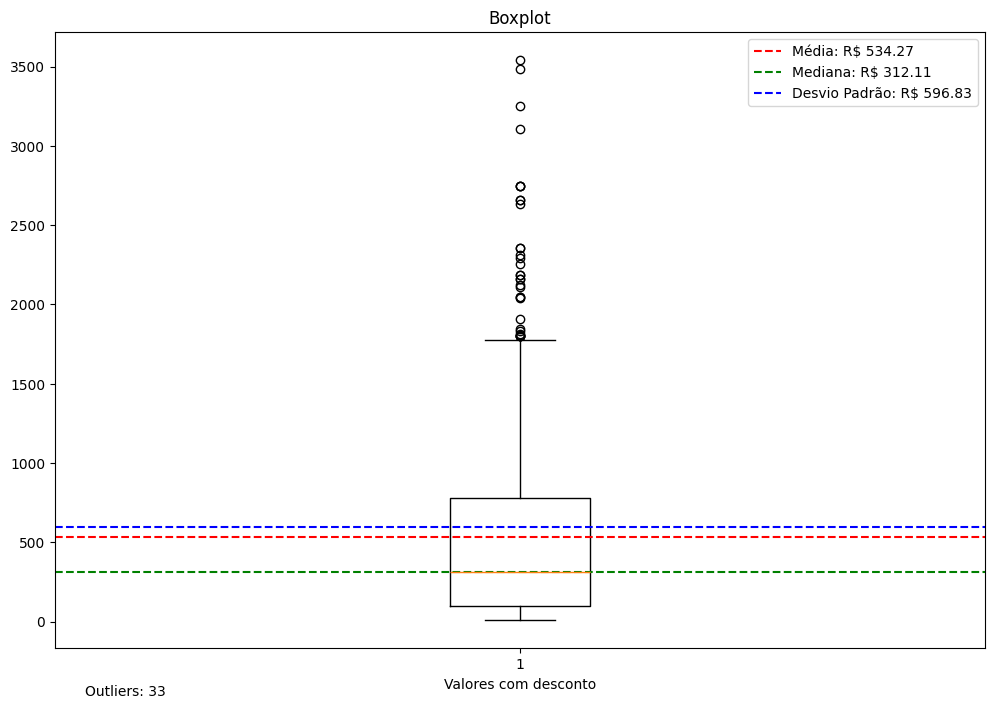

In [24]:
import concurrent.futures  # Importa a biblioteca para execução concorrente
import csv  # Importa a biblioteca para manipulação de arquivos CSV
import numpy as np  # Importa a biblioteca NumPy para cálculos numéricos
# Importa a biblioteca Pandas para manipulação de dados em formato tabular
import pandas as pd
import requests  # Importa a biblioteca para fazer solicitações HTTP
from bs4 import BeautifulSoup  # Importa a classe BeautifulSoup para análise de HTML
# Importa a biblioteca Matplotlib para plotagem de gráficos
import matplotlib.pyplot as plt


def obter_produtos_da_pagina(url):
    # Função para obter os produtos de uma página web
    # Faz uma solicitação HTTP GET para a URL fornecida
    response = requests.get(url)
    response.raise_for_status()  # Verifica se houve algum erro na solicitação
    html = response.text  # Obtém o conteúdo HTML da resposta
    # Analisa o HTML usando BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Encontra todos os itens de promoção na página
    itens = soup.find_all('li', class_='promotion-item')

    produtos = []  # Inicializa uma lista para armazenar os produtos encontrados

    for item in itens:  # Itera sobre cada item de promoção encontrado
        # Encontra o elemento do nome do produto
        nome_elemento = item.find('p', class_='promotion-item__title')
        # Encontra o elemento do preço original
        preco_original_elemento = item.find(
            'span', class_='andes-money-amount__fraction')
        # Encontra o elemento do desconto
        desconto_elemento = item.find(
            'span', class_='promotion-item__discount-text')

        # Remove caracteres não numéricos e converte o preço original para float
        preco_original_texto = preco_original_elemento.text.strip().replace(
            'R$', '').replace('.', '').replace(',', '.')
        preco_original = float(
            preco_original_texto) if preco_original_texto else 0
        
        desconto = 0

        if desconto_elemento:  # Verifica se há desconto
            desconto_texto = desconto_elemento.text.strip().replace('% OFF', '').replace(
                # Remove caracteres não numéricos do desconto
                '%', '').replace('no Pix', '')
            if desconto_texto:  # Verifica se a string do desconto não está vazia
                # Converte o desconto para float
                desconto = float(desconto_texto) / 100
        else:
            desconto = 0  # Define o desconto como 0 se não houver desconto

        # Calcula o valor final do produto com desconto
        valor_final = preco_original * (1 - desconto)

        if desconto > 0.15:  # Filtra produtos com desconto maior que 15%
            produtos.append({  # Adiciona os detalhes do produto à lista de produtos
                'Nome': nome_elemento.text.strip(),
                'Preço Original': preco_original,
                'Desconto': desconto_elemento.text.strip() if desconto_elemento else '0% OFF',
                'Valor Final': valor_final
            })

    return produtos  # Retorna a lista de produtos obtidos da página


def obter_todos_produtos():
    # Função para obter todos os produtos de todas as páginas de ofertas
    # URL base para as páginas de ofertas
    url_base = 'https://www.mercadolivre.com.br/ofertas?page='
    produtos = []  # Inicializa uma lista para armazenar todos os produtos encontrados

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Mapeia a função obter_produtos_da_pagina para cada página em paralelo
        paginas = [executor.submit(
            obter_produtos_da_pagina, url_base + str(pagina)) for pagina in range(1, 21)]

        # Coleta os resultados das páginas conforme estão disponíveis
        for pagina in concurrent.futures.as_completed(paginas):
            # Adiciona os produtos da página ao resultado final
            produtos.extend(pagina.result())

    return produtos  # Retorna a lista de todos os produtos encontrados


def gerar_csv(produtos, nome_arquivo):
    # Função para gerar um arquivo CSV com os produtos
    campos = ['Nome', 'Preço Original', 'Desconto',
            'Valor Final']  # Define os campos do arquivo CSV

    with open(nome_arquivo, mode='w', newline='', encoding='utf-8') as arquivo_csv:
        # Inicializa o escritor CSV
        escritor_csv = csv.DictWriter(arquivo_csv, fieldnames=campos)
        escritor_csv.writeheader()  # Escreve os cabeçalhos no arquivo CSV
        escritor_csv.writerows(produtos)  # Escreve os produtos no arquivo CSV


def gerar_excel(produtos, nome_arquivo_excel):
    # Função interna para formatar valores como moeda
    def formatar_valores(valor):
        return f'R$ {valor:.2f}'

    # Criar DataFrame e aplicar formatação
    df = pd.DataFrame(produtos)
    df['Preço Original'] = df['Preço Original'].apply(formatar_valores)
    df['Valor Final'] = df['Valor Final'].apply(formatar_valores)

    # Salvar DataFrame em um arquivo Excel
    df.to_excel(nome_arquivo_excel, index=False)

def gerar_boxplot(produtos):
    # Função para gerar um boxplot dos valores finais dos produtos
    # Extrai os valores finais dos produtos
    valores_finais = [produto['Valor Final'] for produto in produtos]
    media = np.mean(valores_finais)  # Calcula a média dos valores finais
    mediana = np.median(valores_finais)  # Calcula a mediana dos valores finais
    # Calcula o desvio padrão dos valores finais
    desvio_padrao = np.std(valores_finais)
    # Calcula a variância dos valores finais
    variancia = np.var(valores_finais)
    # Calcula os limites superior e inferior para identificar outliers
    Q1 = np.percentile(valores_finais, 25)
    Q3 = np.percentile(valores_finais, 75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # Conta a quantidade de outliers
    outliers = sum((x < lim_inf or x > lim_sup) for x in valores_finais)

    # Plota o boxplot
    
    # Define o tamanho do gráfico
    plt.figure(figsize=(12, 8))
    
    # Diz quais valores serão utilizados e a orientação do boxplot
    plt.boxplot(valores_finais, vert=True)
    
    # Diz o título do gráfico 
    plt.title('Boxplot')
    
    # Adiciona legenda
    plt.xlabel('Valores com desconto')
    
    # Define as configuraões das linhas
    plt.axhline(y=media, color='r', linestyle='--',
                label=f'Média: R$ {media:.2f}')
    plt.axhline(y=mediana, color='g', linestyle='--',
                label=f'Mediana: R$ {mediana:.2f}')
    plt.axhline(y=desvio_padrao, color='b', linestyle='--',
                label=f'Desvio Padrão: R$ {desvio_padrao:.2f}')
    # O valor da variância é muito alto, então não é possível visualizar no gráfico sem prejudicar a visualização
    # plt.axhline(y=variancia, color='y', linestyle='--',
    #             label=f'Variância: R$ {variancia:.2f}')
    # Define a quantidade de outliers no gráfico
    plt.figtext(0.15, 0.05, f'Outliers: {outliers}')
    
    # Adiciona legenda
    plt.legend()
    
    # Mostra o gráfico
    plt.show()


if __name__ == "__main__":
    # Obtém todos os produtos de todas as páginas
    produtos = obter_todos_produtos()
    
    # Ordena os produtos por nome
    produtos.sort(key=lambda x: x['Nome'])

    # Gerar CSV
    nome_arquivo_csv = 'produtos.csv'
    gerar_csv(produtos, nome_arquivo_csv)
    print(f"Arquivo CSV '{nome_arquivo_csv}' gerado com sucesso!")

    # Gerar Excel
    nome_arquivo_excel = 'produtos.xlsx'
    gerar_excel(produtos, nome_arquivo_excel)
    print(f"Arquivo Excel '{nome_arquivo_excel}' gerado com sucesso!")

    # Gerar Boxplot
    gerar_boxplot(produtos)
    
    